# Unified Architecture

> **Created by:** Mario Boley  
> **On:** 2025-06-16

This study aims to develop a unified architecture that allows (in order of importance):

1. Code reuse between different loss function, in particular for classifiers and regressors
2. Code reuse between different boosting routines, including different objective functions
3. Incremental computation of the Gramian and potentially other objects across boosting iterations
4. Use of numba jit for the main boosting loop
5. Use of other, i.e., non-rule, base learners

## Test Data

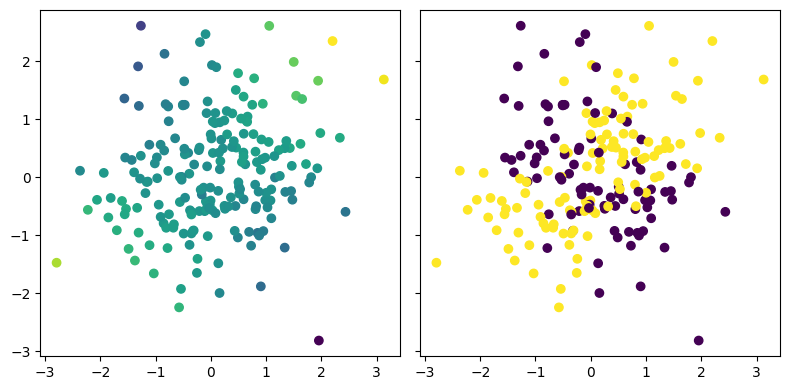

In [30]:
import numpy as np
from scipy.special import expit
from matplotlib import pyplot as plt

RNG = np.random.default_rng(0)

cov = np.array(
    [[1, 0.2], 
     [0.2, 1]]
)

n = 200
x = RNG.multivariate_normal([0, 0], cov, size=n)
y_regr = x[:, 0] * x[:, 1] + RNG.normal(scale=0.25, size=n)
y_class = RNG.binomial(n=1, p=expit(4 * x[:, 0] * x[:, 1]))

_, axs = plt.subplots(1, 2, figsize=(8, 4), sharey=True, tight_layout=True)
axs[0].scatter(x[:, 0], x[:, 1], c=y_regr)
axs[1].scatter(x[:, 0], x[:, 1], c=y_class)
plt.show()

## Specialised Rule Boosting Regression Implementation

This implementation is taken from the [shrinkage spike](shrinkage.ipynb). It contains the options for a background rule, $l2$-regularisation, and norm-based normalisation during fitting.

In [31]:
from optikon import max_weighted_support, equal_width_propositionalization
from sklearn.metrics import mean_squared_error

class RuleBoostingRegressor:

    def __init__(self, num_rules=3, fit_intercept=True, lam=0.0, normalize_during_weight_fit=False, max_depth=5):
        self.num_rules = num_rules
        self.fit_intercept = fit_intercept
        self.max_depth = max_depth
        self.normalize_during_weight_fit = normalize_during_weight_fit
        self.lam = lam

    def fit(self, x, y):
        n = len(x)
        props = equal_width_propositionalization(x)
        
        q_matrix = np.zeros(shape=(n, self.num_rules+self.fit_intercept))

        if self.fit_intercept:
            self.q_ = [props[:0]]
            q_matrix[:, 0] = 1
            self.coef_ = np.array([y.mean()])
        else:
            self.q_ = []
            q_matrix = np.zeros(shape=(n, self.num_rules))
            self.coef_ = np.zeros(shape=0)

        for i in range(self.fit_intercept, self.num_rules+self.fit_intercept):
            y_hat = q_matrix[:, :i].dot(self.coef_) 
            g = y - y_hat

            opt_key_pos, opt_val_pos, _, _ = max_weighted_support(x, g, props, self.max_depth)
            opt_key_neg, opt_val_neg, _, _ = max_weighted_support(x, -g, props, self.max_depth)
            if opt_val_pos >= opt_val_neg:
                self.q_.append(props[opt_key_pos])
            else:
                self.q_.append(props[opt_key_neg])

            q_matrix[self.q_[i].support_all(x), i] = 1
            self._fit_coefficients(y, q_matrix[:, :i+1])

        return self

    def _fit_coefficients(self, y, q_matrix):
        
        if self.normalize_during_weight_fit:
            b = q_matrix.sum(axis=0)**0.5 / len(y)**0.5
            q_matrix = q_matrix / b

        gramian = q_matrix.T.dot(q_matrix)

        if self.lam > 0:
            if self.fit_intercept:
                gramian[np.diag_indices_from(gramian)[0][1:], np.diag_indices_from(gramian)[1][1:]] += self.lam
            else:
                gramian[np.diag_indices_from(gramian)] += self.lam

        self.coef_ = np.linalg.solve(gramian, q_matrix.T.dot(y))

        if self.normalize_during_weight_fit:
            self.coef_ /= b
    
    def predict(self, x):
        q_matrix = self._compute_q_matrix(x)
        return q_matrix.dot(self.coef_)

    def _compute_q_matrix(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix
    
    def __str__(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} {'\n' if i<len(self.q_)-1 else ''}'
        return res
    
    def __repr__(self):
        return f'RuleBoostingRegressor({self.num_rules}, {self.max_depth})'
    
regressor = RuleBoostingRegressor(num_rules=3, fit_intercept=True, lam=1).fit(x, y_regr)
print(regressor)
mean_squared_error(y_regr, regressor.predict(x))



+0.472 if  
+2.090 if x1 >= 0.458 & x2 >= 0.059 
-1.239 if x1 >= 0.458 & x2 <= 1.292 
-0.774 if x1 <= 1.388 & x2 >= 0.059 


0.6145157052479907

## Separation of Loss Function and Boosting Loop

In [32]:
class PythonIncrementalSquaredLossOptimizer:

    def __init__(self, y, max_features, intercept=True, lam=0.0):
        self.y = y
        self.max_features = max_features
        self.intercept = intercept
        self.x = np.zeros(shape=(len(y), self.max_features+self.intercept))
        self.lam = lam

        if self.intercept:
            self.x[:, 0] = 1
            self.coef = np.array([y.mean()])
            self.current_features = 1
        else:
            self.coef = np.zeros(shape=0)
            self.current_features = 0

    def add_feature(self, col):
        self.x[:, self.current_features] = col
        self.current_features += 1

    def add_sparse_feature(self, idx, vals):
        self.x[idx, self.current_features] = vals
        self.current_features += 1

    def gradient(self):
        return self.y - self.x[:, :self.current_features].dot(self.coef)

    def hessian_diagonal(self):
        return 1

    def optimize_coefficients(self):
        gramian = self.x[:, :self.current_features].T.dot(self.x[:, :self.current_features])

        # n = self.current_features
        # if self.lam > 0:
        #     if self.intercept:
        #         for i in range(1, n):
        #             gramian[i, i] += self.lam
        #     else:
        #         for i in range(n):
        #             gramian[i, i] += self.lam

        # if self.lam > 0:
        #     for i in range(self.intercept, self.current_features):
        #         gramian[i, i] += self.lam

        if self.lam > 0:
            if self.intercept:
                gramian[np.diag_indices_from(gramian)[0][1:], np.diag_indices_from(gramian)[1][1:]] += self.lam
            else:
                gramian[np.diag_indices_from(gramian)] += self.lam
            
        self.coef = np.linalg.solve(gramian, self.x[:, :self.current_features].T.dot(self.y))



def python_gradient_sum_booster(x, props, num_rules, fit_intercept, coefficient_optimizer, max_depth=5):
    qs = []
    if fit_intercept:
        qs.append(props[0:0]) 
    # qs = [props[:0]] if fit_intercept else []
    for _ in range(num_rules):
        g = coefficient_optimizer.gradient()

        opt_key_pos, opt_val_pos, _, _ = max_weighted_support(x, g, props, max_depth)
        opt_key_neg, opt_val_neg, _, _ = max_weighted_support(x, -g, props, max_depth)
        if opt_val_pos >= opt_val_neg:
            qs.append(props[opt_key_pos])
        else:
            qs.append(props[opt_key_neg])

        coefficient_optimizer.add_sparse_feature(qs[-1].support_all(x), 1)
        coefficient_optimizer.optimize_coefficients()
    return coefficient_optimizer.coef, qs

class PythonNewRuleBoostingRegressor:

    def __init__(self, num_rules=3, fit_intercept=True, lam=0.0, max_depth=5):
        self.num_rules = num_rules
        self.fit_intercept = fit_intercept
        self.max_depth = max_depth
        self.lam = lam

    def fit(self, x, y):
        optimizer = PythonIncrementalSquaredLossOptimizer(y, self.num_rules, intercept=self.fit_intercept, lam=self.lam)
        props = equal_width_propositionalization(x)
        self.coef_, self.q_ = python_gradient_sum_booster(x, props, self.num_rules, fit_intercept=self.fit_intercept, coefficient_optimizer=optimizer, max_depth=self.max_depth)
        return self
    
    def predict(self, x):
        q_matrix = self._compute_q_matrix(x)
        return q_matrix.dot(self.coef_)

    def _compute_q_matrix(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix
    
    def __str__(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} {'\n' if i<len(self.q_)-1 else ''}'
        return res
    
    def __repr__(self):
        return f'PythonNewRuleBoostingRegressor({self.num_rules}, {self.max_depth})'

python_new_regressor = PythonNewRuleBoostingRegressor(num_rules=3, fit_intercept=True, lam=1).fit(x, y_regr)
print(python_new_regressor)
mean_squared_error(y_regr, python_new_regressor.predict(x))

+0.472 if  
+2.090 if x1 >= 0.458 & x2 >= 0.059 
-1.239 if x1 >= 0.458 & x2 <= 1.292 
-0.774 if x1 <= 1.388 & x2 >= 0.059 


0.6145157052479907

In [33]:
class PythonFullyIncrementalSquaredLossOptimizer:

    def __init__(self, y, max_features, intercept=True, lam=0.0):
        self.y = y
        self.max_features = max_features
        self.intercept = intercept
        self.x = np.zeros(shape=(len(y), self.max_features+self.intercept))
        self.gramian = np.zeros((self.max_features+self.intercept, self.max_features+self.intercept)) #
        self.lam = lam

        if self.intercept:
            self.x[:, 0] = 1
            self.gramian[0, 0] = len(y)
            self.coef = np.array([y.mean()])
            self.current_features = 1
        else:
            self.coef = np.zeros(shape=0)
            self.current_features = 0

    def add_feature(self, col):
        k = self.current_features
        self.x[:, k] = col
        self.gramian[:k+1, k] = self.x[:, :k+1].T.dot(col)
        self.gramian[k, :k+1] = self.gramian[:k+1, k]
        self.gramian[k, k] += self.lam
        self.current_features += 1

    def add_sparse_feature(self, idx, vals):
        self.x[idx, self.current_features] = vals
        k = self.current_features
        # self.gramian[:k+1, k] = self.x[:, :k+1].T.dot(self.x[:, k])
        for j in range(k+1):
            self.gramian[j, k] = np.dot(self.x[:, j], self.x[:, k])
        self.gramian[k, :k+1] = self.gramian[:k+1, k]
        self.gramian[k, k] += self.lam
        self.current_features += 1

    def gradient(self):
        return self.y - self.x[:, :self.current_features].dot(self.coef)

    def hessian_diagonal(self):
        return 1

    def optimize_coefficients(self):
        gramian = self.gramian[:self.current_features, :self.current_features] # self.x[:, :self.current_features].T.dot(self.x[:, :self.current_features])
        self.coef = np.linalg.solve(gramian, self.x[:, :self.current_features].T.dot(self.y))

class PythonIncrementalNewRuleBoostingRegressor:

    def __init__(self, num_rules=3, fit_intercept=True, lam=0.0, max_depth=5):
        self.num_rules = num_rules
        self.fit_intercept = fit_intercept
        self.max_depth = max_depth
        self.lam = lam

    def fit(self, x, y):
        optimizer = PythonFullyIncrementalSquaredLossOptimizer(y, self.num_rules, intercept=self.fit_intercept, lam=self.lam)
        props = equal_width_propositionalization(x)
        self.coef_, self.q_ = python_gradient_sum_booster(x, props, self.num_rules, fit_intercept=self.fit_intercept, coefficient_optimizer=optimizer, max_depth=self.max_depth)
        return self
    
    def predict(self, x):
        q_matrix = self._compute_q_matrix(x)
        return q_matrix.dot(self.coef_)

    def _compute_q_matrix(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix
    
    def __str__(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} {'\n' if i<len(self.q_)-1 else ''}'
        return res
    
    def __repr__(self):
        return f'PythonIncrementalNewRuleBoostingRegressor({self.num_rules}, {self.max_depth})'

python_new_regressor = PythonIncrementalNewRuleBoostingRegressor(num_rules=20, fit_intercept=True, lam=1).fit(x, y_regr)
print(python_new_regressor)
mean_squared_error(y_regr, python_new_regressor.predict(x))

+0.101 if  
+1.066 if x1 >= 0.458 & x2 >= 0.059 
-1.353 if x1 >= 0.458 & x2 <= 1.292 
-0.881 if x1 <= 1.388 & x2 >= 0.059 
-0.334 if x1 >= -1.400 & x1 <= 0.006 & x2 >= -1.174 
-0.287 if x1 >= 0.471 & x2 <= 0.352 
+0.670 if x1 <= 0.006 & x2 <= 0.352 
+0.844 if x1 >= 0.471 & x2 >= -1.174 
-0.821 if x1 >= 0.471 & x2 <= 0.881 
+0.555 if x1 <= 1.388 & x2 <= 0.881 
-1.072 if x1 >= -1.864 & x1 <= 0.923 & x2 >= -1.174 
+0.738 if x1 >= -1.400 & x1 <= 0.923 & x2 >= 0.059 & x2 <= 1.703 
-0.890 if x1 >= -2.329 & x1 <= 2.317 & x2 <= 2.115 
+1.006 if x1 >= 0.935 & x2 >= 0.470 
+0.872 if x1 <= 0.923 & x2 >= -1.585 & x2 <= 0.470 
+0.351 if x1 >= 0.458 & x1 <= 1.852 & x2 >= 0.763 & x2 <= 0.470 
+1.113 if x1 >= -1.864 & x2 >= -2.407 & x2 <= 2.526 
-0.814 if x1 >= 0.935 & x1 <= 2.781 & x2 <= 1.703 
+0.533 if x1 >= 0.935 & x1 <= 2.317 & x2 >= -2.407 & x2 <= 1.292 
-0.596 if x1 >= -1.864 & x1 <= 0.458 & x2 >= -1.585 
+0.317 if x1 >= -2.329 & x2 >= -1.174 & x2 <= 1.703 


0.1229030272149968

In [40]:
%timeit PythonNewRuleBoostingRegressor(num_rules=100, fit_intercept=True, lam=1).fit(x, y_regr)

4.44 s ± 28.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [41]:
%timeit PythonIncrementalNewRuleBoostingRegressor(num_rules=100, fit_intercept=True, lam=1).fit(x, y_regr)

4.47 s ± 31.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Numba Implementation

In [43]:
from numba.experimental import jitclass
from numba.types import float64, boolean, int64
from numba import njit
from numba.typed import List

spec = [
    ('y', float64[:]),
    ('x', float64[:, :]),
    ('coef', float64[:]),
    ('lam', float64),
    ('intercept', boolean),
    ('max_features', int64),
    ('current_features', int64),
]
@jitclass(spec)
class IncrementalSquaredLossOptimizer:

    def __init__(self, y, max_features, intercept=True, lam=0.0):
        self.y = y
        self.max_features = max_features
        self.intercept = intercept
        self.x = np.zeros(shape=(len(y), self.max_features+self.intercept))
        self.lam = lam

        if self.intercept:
            self.x[:, 0] = 1
            self.coef = np.array([y.mean()])
            self.current_features = 1
        else:
            self.coef = np.zeros(shape=0)
            self.current_features = 0

    def add_feature(self, col):
        self.x[:, self.current_features] = col
        self.current_features += 1

    def add_sparse_feature(self, idx, vals):
        self.x[idx, self.current_features] = vals
        self.current_features += 1

    def gradient(self):
        return self.y - self.x[:, :self.current_features].dot(self.coef)

    def hessian_diagonal(self):
        return 1

    def optimize_coefficients(self):
        gramian = self.x[:, :self.current_features].T.dot(self.x[:, :self.current_features])

        if self.lam > 0:
            for i in range(self.intercept, self.current_features):
                gramian[i, i] += self.lam
            
        self.coef = np.linalg.solve(gramian, self.x[:, :self.current_features].T.dot(self.y))

spec2 = [
    ('y', float64[:]),
    ('x', float64[:, :]),
    ('coef', float64[:]),
    ('lam', float64),
    ('intercept', boolean),
    ('max_features', int64),
    ('current_features', int64),
    ('gramian', float64[:, :]),  # make sure this matches actual layout
]
@jitclass(spec2)
class FullyIncrementalSquaredLossOptimizer:

    def __init__(self, y, max_features, intercept=True, lam=0.0):
        self.y = y
        self.max_features = max_features
        self.intercept = intercept
        self.x = np.zeros(shape=(len(y), self.max_features+self.intercept))
        self.gramian = np.zeros((self.max_features+self.intercept, self.max_features+self.intercept)) #
        self.lam = lam

        if self.intercept:
            self.x[:, 0] = 1
            self.gramian[0, 0] = len(y)
            self.coef = np.array([y.mean()])
            self.current_features = 1
        else:
            self.coef = np.zeros(shape=0)
            self.current_features = 0

    def add_feature(self, col):
        k = self.current_features
        self.x[:, k] = col
        self.gramian[:k+1, k] = self.x[:, :k+1].T.dot(col)
        self.gramian[k, :k+1] = self.gramian[:k+1, k]
        self.gramian[k, k] += self.lam
        self.current_features += 1

    def add_sparse_feature(self, idx, vals):
        self.x[idx, self.current_features] = vals
        k = self.current_features
        # self.gramian[:k+1, k] = self.x[:, :k+1].T.dot(self.x[:, k])
        for j in range(k+1):
            self.gramian[j, k] = np.dot(self.x[:, j], self.x[:, k])
        self.gramian[k, :k+1] = self.gramian[:k+1, k]
        self.gramian[k, k] += self.lam
        self.current_features += 1

    def gradient(self):
        return self.y - self.x[:, :self.current_features].dot(self.coef)

    def hessian_diagonal(self):
        return 1

    def optimize_coefficients(self):
        gramian = self.gramian[:self.current_features, :self.current_features] # self.x[:, :self.current_features].T.dot(self.x[:, :self.current_features])
        self.coef = np.linalg.solve(gramian, self.x[:, :self.current_features].T.dot(self.y))

@njit
def gradient_sum_booster(x, props, num_rules, fit_intercept, coefficient_optimizer, max_depth=5):
    qs = List()
    if fit_intercept:
        qs.append(props[0:0]) 
    # qs = [props[:0]] if fit_intercept else []
    for _ in range(num_rules):
        g = coefficient_optimizer.gradient()

        opt_key_pos, opt_val_pos, _, _ = max_weighted_support(x, g, props, max_depth)
        opt_key_neg, opt_val_neg, _, _ = max_weighted_support(x, -g, props, max_depth)
        if opt_val_pos >= opt_val_neg:
            qs.append(props[opt_key_pos])
        else:
            qs.append(props[opt_key_neg])

        coefficient_optimizer.add_sparse_feature(qs[-1].support_all(x), 1)
        coefficient_optimizer.optimize_coefficients()
    return coefficient_optimizer.coef, qs

class NumbaNewRuleBoostingRegressor:

    def __init__(self, num_rules=3, fit_intercept=True, lam=0.0, max_depth=5):
        self.num_rules = num_rules
        self.fit_intercept = fit_intercept
        self.max_depth = max_depth
        self.lam = lam

    def fit(self, x, y):
        optimizer = FullyIncrementalSquaredLossOptimizer(y, self.num_rules, intercept=self.fit_intercept, lam=self.lam)
        props = equal_width_propositionalization(x)
        self.coef_, self.q_ = gradient_sum_booster(x, props, self.num_rules, fit_intercept=self.fit_intercept, coefficient_optimizer=optimizer, max_depth=self.max_depth)
        return self
    
    def predict(self, x):
        q_matrix = self._compute_q_matrix(x)
        return q_matrix.dot(self.coef_)

    def _compute_q_matrix(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix
    
    def __str__(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} {'\n' if i<len(self.q_)-1 else ''}'
        return res
    
    def __repr__(self):
        return f'NewRuleBoostingRegressor({self.num_rules}, {self.max_depth})'


new_regressor = NumbaNewRuleBoostingRegressor(num_rules=3, fit_intercept=True, lam=1).fit(x, y_regr)
print(new_regressor)
mean_squared_error(y_regr, new_regressor.predict(x))


/var/folders/zw/qxvhv2ms1rx684818_y1cvl40000gn/T/ipykernel_82541/3566548927.py:130: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 1, 'A', False, aligned=True), Array(float64, 1, 'A', False, aligned=True))
  coefficient_optimizer.add_sparse_feature(qs[-1].support_all(x), 1)


+0.472 if  
+2.090 if x1 >= 0.458 & x2 >= 0.059 
-1.239 if x1 >= 0.458 & x2 <= 1.292 
-0.774 if x1 <= 1.388 & x2 >= 0.059 


0.6145157052479907

In [44]:
%timeit NumbaNewRuleBoostingRegressor(num_rules=100, fit_intercept=True, lam=1).fit(x, y_regr)

4.5 s ± 38.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [6]:
%timeit PythonNewRuleBoostingRegressor(num_rules=200, fit_intercept=True, lam=1).fit(x, y_regr)

1.74 s ± 11.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [84]:
%timeit PythonNewRuleBoostingRegressor(num_rules=200, fit_intercept=True, lam=1).fit(x, y_regr)

1.86 s ± 36.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [16]:
%timeit NumbaNewRuleBoostingRegressor(num_rules=200, fit_intercept=True, lam=1).fit(x, y_regr)

1.71 s ± 9.72 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## Classifier

In [98]:
from sklearn.base import BaseEstimator

@njit
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

@njit
def numba_rawnewton_logreg(x, y, lam, max_iter=100, tol=1e-6):
    _, d = x.shape
    beta = np.zeros(d)
    
    for _ in range(max_iter):
        p = sigmoid(x.dot(beta))
        grad = x.T @ (p - y) + 2 * lam * beta
        s = p * (1 - p)
        h = x.T @ (x * s[:, None]) + 2 * lam * np.eye(d)
        delta = np.linalg.solve(h, grad)
        beta -= delta
        if np.linalg.norm(delta) < tol:
            break
    return beta

@jitclass
class IncrementalLogisticLossOptimizer:

    y: int64[:]
    max_features: int64
    intercept: boolean
    lam: float64
    x: float64[:, :]
    coef: float64[:]
    current_features: int64

    def __init__(self, y, max_features, intercept=True, lam=0.0):
        self.y = y
        self.max_features = max_features
        self.intercept = intercept
        self.x = np.zeros(shape=(len(y), self.max_features+self.intercept), dtype=np.float64)
        self.lam = lam

        if self.intercept:
            self.x[:, 0] = 1
            self.coef = np.array([y.mean()]).astype(np.float64)
            self.current_features = 1
        else:
            self.coef = np.zeros(shape=0, dtype=np.float64)
            self.current_features = 0

    def add_feature(self, col):
        self.x[:, self.current_features] = col
        self.current_features += 1

    def add_sparse_feature(self, idx, vals):
        self.x[idx, self.current_features] = vals
        self.current_features += 1

    def gradient(self):
        return sigmoid(self.x[:, :self.current_features].dot(self.coef)) - self.y

    def hessian_diagonal(self):
        p = sigmoid(self.x[:, :self.current_features].dot(self.coef))
        return p*(1-p)

    def optimize_coefficients(self):
        self.coef = numba_rawnewton_logreg(self.x[:, :self.current_features], self.y, self.lam)


class BaseRuleBoostingEstimator(BaseEstimator):

    def __init__(self, coefficient_optimizer_class, num_rules=3, fit_intercept=True, lam=0.0, max_depth=5):
        self.num_rules = num_rules
        self.fit_intercept = fit_intercept
        self.max_depth = max_depth
        self.lam = lam
        self.coefficient_optimizer_class = coefficient_optimizer_class

    def fit(self, x, y):
        optimizer = self.coefficient_optimizer_class(y, self.num_rules, intercept=self.fit_intercept, lam=self.lam)
        props = equal_width_propositionalization(x)
        self.coef_, self.q_ = gradient_sum_booster(x, props, self.num_rules, fit_intercept=self.fit_intercept, coefficient_optimizer=optimizer, max_depth=self.max_depth)
        return self
    
    def predict(self, x):
        q_matrix = self.transform(x)
        return q_matrix.dot(self.coef_)

    def transform(self, x):
        n = len(x)
        q_matrix = np.zeros(shape=(n, len(self.q_)))
        for i in range(len(self.q_)):
            q_matrix[self.q_[i].support_all(x), i] = 1
        return q_matrix
    
    def rules_str(self):
        res = ''
        for i in range(len(self.q_)):
            res += f'{self.coef_[i]:+.3f} if {self.q_[i].str_from_conj(np.arange(len(self.q_[i])))} {'\n' if i<len(self.q_)-1 else ''}'
        return res


class RuleBoostingClassifier(BaseRuleBoostingEstimator):

    def __init__(self, num_rules=3, fit_intercept=True, lam=1.0, max_depth=5):
        super().__init__(IncrementalLogisticLossOptimizer, num_rules, fit_intercept, lam, max_depth)

    def fit(self, x, y):
        self.classes_, y_encoded = np.unique(y, return_inverse=True)
        return super().fit(x, y_encoded)

    def predict_proba(self, x):
        res = np.zeros((len(x), len(self.classes_)))
        res[:, 1] = sigmoid(super().predict(x))
        res[:, 0] = 1 - res[:, 1]
        return res
    
    def predict(self, x):
        return self.classes_[(super().predict(x)>=0.0).astype(np.int64)]
    
classifier = RuleBoostingClassifier(num_rules=3)
classifier


,num_rules,3
,fit_intercept,True
,lam,1.0
,max_depth,5


In [99]:
classifier.fit(x, y_class)

,num_rules,3
,fit_intercept,True
,lam,1.0
,max_depth,5


In [101]:
print(classifier.rules_str())

+0.925 if  
-1.968 if x1 >= -1.864 & x1 <= 0.006 & x2 >= 0.352 
-1.714 if x1 >= 0.006 & x2 <= 0.059 
+0.933 if x1 <= 0.471 & x2 <= 0.059 


In [102]:
(classifier.predict(x) != y_class).mean()

np.float64(0.19)

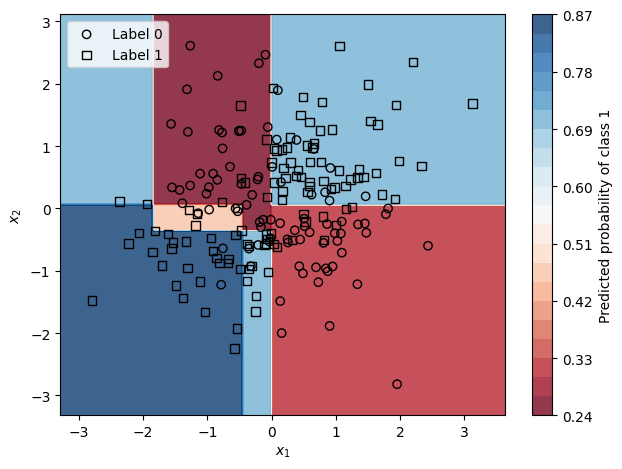

In [106]:
x0, x1 = x[:, 0], x[:, 1]

xx, yy = np.meshgrid(
    np.linspace(x0.min() - 0.5, x0.max() + 0.5, 200),
    np.linspace(x1.min() - 0.5, x1.max() + 0.5, 200)
)
grid = np.c_[xx.ravel(), yy.ravel()]
probs = classifier.predict_proba(grid)[:, 1].reshape(xx.shape)

cf = plt.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.8)
for label, marker in zip([0, 1], ['o', 's']):
    idx = (y_class == label)
    plt.scatter(x[idx, 0], x[idx, 1], marker=marker,
                facecolors='none', edgecolors='k', label=f"Label {label}")

plt.colorbar(cf, label="Predicted probability of class 1")

plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.legend()
plt.tight_layout()
plt.show()